In [1]:
import numpy as np
import cvxpy as cvx
import control as ctrl
import scipy.linalg as linalg
import matplotlib.pyplot as plt 
from tqdm import tqdm
from fct.lyapunov_matrix import PolynomialLyapunovMatrix
from fct.algorithms import GradientDescent, Nesterov, TMM

In [2]:
# Helper functions

def lti_stack(sys1, sys2):
    A1, B1, C1, D1 = ctrl.ssdata(sys1)
    A2, B2, C2, D2 = ctrl.ssdata(sys2)

    if B1.shape[1] != B2.shape[1]:
        raise ValueError('Error in system stacking: number of inputs must be the same for both subsystems!')

    A = linalg.block_diag(A1, A2)
    B = np.vstack((B1, B2))
    C = linalg.block_diag(C1, C2)
    D = np.vstack((D1, D2))

    return ctrl.ss(A, B, C, D, dt=1)


def consistent_polytope_nd(params, delta_params_min, delta_params_max, step_size=0.1):
    """
    Generates grid points such that p_min <= p + delta_p <= p_max
    and delta_p_min <= delta_p <= delta_p_max for each parameter vector.

    Parameters:
        params (numpy.ndarray): A 2D array where each row represents a parameter vector.
        delta_params_min (numpy.ndarray): Minimum allowable deltas for each parameter.
        delta_params_max (numpy.ndarray): Maximum allowable deltas for each parameter.
        step_size (float): Step size for generating grid points in the delta ranges.

    Returns:
        list: A list of tuples, each containing (p_k, delta_p) where p_k is the parameter vector
              and delta_p is the corresponding delta vector satisfying the constraints.
    """
    # Handle 1D input by converting it to 2D for uniform processing
    if params.ndim == 1:
        params = params[None, :]  # Convert to shape (1, n)
        delta_params_min = np.array([delta_params_min])
        delta_params_max = np.array([delta_params_max])

    # Calculate global min and max for params directly using numpy
    p_min = np.min(params, axis=1)
    p_max = np.max(params, axis=1)

    # Initialize the grid points for (p, delta_p)
    grid_points = []

    # Loop through each parameter vector
    for k in range(params.shape[1]):
        p_k = params[:, k]

        # Determine feasible ranges for deltas for each dimension
        delta_min_k = np.maximum(delta_params_min, np.maximum(p_min - p_k, -delta_params_max))
        delta_max_k = np.minimum(delta_params_max, np.minimum(p_max - p_k, delta_params_max))

        # Generate grid points for all dimensions
        delta_ranges = []
        for d in range(params.shape[0]):
            delta_min = delta_min_k[d]
            delta_max = delta_max_k[d]
            num_dp_points = int((delta_max - delta_min) / step_size) + 1
            range_points = [
                min(delta_min + j * step_size, delta_max)  # Ensure boundary inclusion
                for j in range(num_dp_points)
            ]
            if range_points[-1] < delta_max:
                range_points.append(delta_max)

            delta_ranges.append(np.array(range_points))

        # Create a meshgrid of delta ranges and iterate through combinations
        delta_mesh = np.meshgrid(*delta_ranges, indexing="ij")
        delta_combinations = np.stack([delta.ravel() for delta in delta_mesh], axis=-1)

        for delta_p in delta_combinations:
            delta_p = np.clip(delta_p, delta_params_min, delta_params_max)
            grid_points.append((p_k, delta_p))

    return grid_points


In [3]:
def bisection(algorithm, delta_model, rho_max, consistent_polytope, eps=1e-6):

    soll = (np.nan, np.nan, np.nan, np.nan, np.nan)

    ### get dimensions ###
    n_xi = algorithm.internal_state_dim
    n_x, n_g  = algorithm.nx, algorithm.nx
    if delta_model:
        n_delt = n_xi
        n_zeta = 1
    else:
        n_delt = 0
        n_zeta = 0
    n_eta = n_xi + n_zeta

    ### start bisection ###
    rho_min = 0
    rho_tol = 1e-3

    while (rho_max-rho_min > rho_tol):

        rho = (rho_min + rho_max)/2

        ### SDP variables ###
        LMI_system = list()
        
        lyap = PolynomialLyapunovMatrix(param_dim=1, poly_degree=2, n_eta=n_eta)

        lambd1 = cvx.Variable(1, nonneg=True)
        
        if delta_model:
            gamm   = cvx.Variable(1, nonneg=True)
            t      = cvx.Variable(1, nonneg=True)
            lambd2 = cvx.Variable(1, nonneg=True)

        ### grid over parameter space ###
        for p_k, delta_p in consistent_polytope:

            p_kp1 = p_k + delta_p

            P_k   = lyap.P(p_k)
            P_kp1 = lyap.P(p_kp1)

            ### algorithm ###
            algorithm.update_algorithm(m=1, L=p_k[0])
            G = algorithm.get_state_space(delta_model=delta_model)

            ### IQCs ###
            A_psi = 0
            B_psi = np.asarray([[-p_k[0], 1]])
            C_psi = np.asarray([[rho**2], [0]])
            D_psi = np.asarray([[p_k[0], -1], [-1, 1]])

            M_sector = np.asarray([[0, 1], [1, 0]])

            if delta_model:
                D_psi_sec = np.block([D_psi, np.zeros((2,n_delt))])

                B_psi = np.block([B_psi, -G.C])
                D_psi = np.block([D_psi, np.zeros((D_psi.shape[0],G.C.shape[1]))])
                M_offby1 = np.asarray([[0, 1], [1, 0]])
            else:
                D_psi_sec = D_psi
                M_offby1 = np.asarray([[0, 1], [1, 0]])

            Psi_sector = ctrl.ss([], [], [], D_psi_sec, dt=1)
            Psi_offby1 = ctrl.ss(A_psi, B_psi, C_psi, D_psi, dt=1)

            ### extended plant ###
            Psi = lti_stack(Psi_sector, Psi_offby1) if delta_model else Psi_sector
            G_I = lti_stack(G, np.eye(n_g+n_delt))
            G_hat = ctrl.series(G_I, Psi)
            A, B, C, D = ctrl.ssdata(G_hat)

            nz1 = M_sector.shape[0]
            nz2 = M_offby1.shape[0]
            nz = nz1 + nz2 if delta_model else nz1

            # set up LMI
            if delta_model:
                # set up LMI
                LMI_inner = cvx.bmat([[-rho**2*P_k, np.zeros((n_eta,n_eta)), np.zeros((n_eta,nz)), np.zeros((n_eta,n_delt))],
                                      [np.zeros((n_eta,n_eta)), P_kp1, np.zeros((n_eta,nz)), np.zeros((n_eta,n_delt))],
                                      [np.zeros((nz,n_eta)), np.zeros((nz,n_eta)), cvx.bmat([[lambd1*M_sector, np.zeros((nz1,nz2))], [np.zeros((nz2,nz1)), lambd2*M_offby1]]), np.zeros((nz,n_delt))], 
                                      [np.zeros((n_delt,n_eta)), np.zeros((n_delt,n_eta)), np.zeros((n_delt,nz)), -cvx.multiply(np.eye(n_delt), gamm)]])
                LMI_outer = cvx.bmat([[np.eye(n_eta), np.zeros((n_eta,n_g+n_delt))],
                                      [cvx.bmat([[A, B]])],
                                      [cvx.bmat([[C, D]])],
                                      [np.zeros((n_delt,n_eta+n_g)), np.eye(n_delt)]])

                LMI = LMI_outer.T @ LMI_inner @ LMI_outer
                LMI = 1/2*(LMI.T + LMI)

                LMI_system.append(P_k << t*np.eye(n_eta))
                LMI_system.append(P_kp1 << t*np.eye(n_eta))

            else:
                LMI1 = cvx.bmat([[A, B]]).T  @ P_kp1 @ cvx.bmat([[A, B]])
                LMI2 = cvx.bmat([[P_k, np.zeros((n_eta,n_g))], [np.zeros((n_g,n_eta)), np.zeros((n_g,n_g))]])
                LMI3 = cvx.bmat([[C, D]]).T  @ M_sector @ cvx.bmat([[C, D]])

                LMI = LMI1 - rho**2 * LMI2 + lambd1 * LMI3

            LMI_system.append(P_k >> eps*np.eye(n_eta))
            LMI_system.append(P_kp1 >> eps*np.eye(n_eta))
            LMI_system.append(LMI << 0)

        # solve problem
        if delta_model:
            problem = cvx.Problem(cvx.Minimize(t+1e-3*gamm+1e-6*(lambd1+lambd2)), LMI_system)
        else:
            problem = cvx.Problem(cvx.Minimize(0), LMI_system)

        try:
            problem.solve(solver=cvx.MOSEK)
        except(cvx.SolverError):
            pass
    
        if problem.status == cvx.OPTIMAL:
            rho_max = rho
            sol = (lyap.min_max_eigval(list(zip(*consistent_polytope))[0]), lambd1, lambd2, gamm, t) if delta_model else (lyap.min_max_eigval(list(zip(*consistent_polytope))[0]), lambd1)
        else:
            rho_min = rho

        del lyap
        
    return rho_max, sol

    

In [ ]:
kappa_range = np.logspace(np.log10(1/0.8 + 1e-3), 2, 10)

rhos_fast, rhos_middle, rhos_slow, rho_nom = (list() for _ in range(4))

n_sparse = 6

### select algorithm
algorithm = GradientDescent(nx=1)
# algorithm = Nesterov(nx=1)
# algorithm = TMM(nx=1)


for kappa in tqdm(kappa_range):

    ### Create consistent polytope grid over parameters
    kappa_min, kappa_max = kappa * 0.8, kappa
    grid_step = (kappa_max - kappa_min) / n_sparse

    params = np.linspace(kappa_min, kappa_max, n_sparse + 1)
    delta_kappa_max = lambda rate_bound: rate_bound * (kappa_max - kappa_min)

    grid_points_fast = consistent_polytope_nd(params, -delta_kappa_max(rate_bound=1), delta_kappa_max(rate_bound=1), step_size=grid_step)
    grid_points_mod  = consistent_polytope_nd(params, -delta_kappa_max(rate_bound=0.5), delta_kappa_max(rate_bound=0.5), step_size=grid_step)
    grid_points_slow = consistent_polytope_nd(params, -delta_kappa_max(rate_bound=0.05), delta_kappa_max(rate_bound=0.05), step_size=grid_step)
    grid_singleton = [(np.array([kappa]), np.array([0]))]


    rho, _ = bisection(algorithm=algorithm,
                            delta_model=True,
                            rho_max=1.5, 
                            consistent_polytope=grid_points_fast,
                            eps=1e-6)
    rhos_fast.append(rho)

    rho, _ = bisection(algorithm=algorithm,
                            delta_model=True,
                            rho_max=1.5, 
                            consistent_polytope=grid_points_mod,
                            eps=1e-6)
    rhos_middle.append(rho)

    rho, _ = bisection(algorithm=algorithm,
                            delta_model=True,
                            rho_max=1.5, 
                            consistent_polytope=grid_points_slow,
                            eps=1e-6)
    rhos_slow.append(rho)

    rho, _ = bisection(algorithm=algorithm,
                            delta_model=True,
                            rho_max=1.5, 
                            consistent_polytope=grid_singleton,
                            eps=1e-6)
    rho_nom.append(rho)


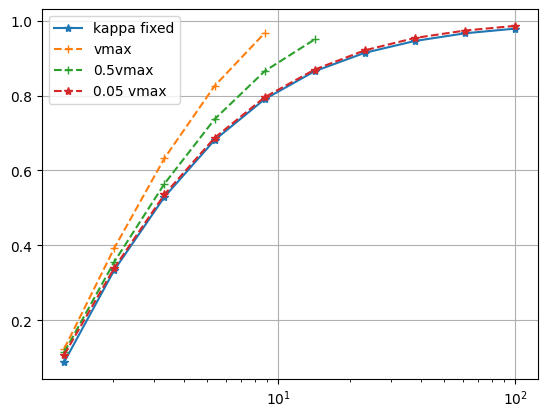

In [6]:
kappa_range, rho_nom, rhos_fast, rhos_middle, rhos_slow = map(np.array, [kappa_range, rho_nom, rhos_fast, rhos_middle, rhos_slow])

plt.semilogx(kappa_range[rho_nom <= 1], rho_nom[rho_nom <= 1], '-*', label='kappa fixed')
plt.semilogx(kappa_range[rhos_fast <= 1], rhos_fast[rhos_fast <= 1], '--+', label='vmax')
plt.semilogx(kappa_range[rhos_middle <= 1], rhos_middle[rhos_middle <= 1], '--+', label='0.5vmax')
plt.semilogx(kappa_range[rhos_slow <= 1], rhos_slow[rhos_slow <= 1], '--*', label='0.05 vmax')

plt.legend()
plt.grid()
plt.show()